In [13]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings("ignore")

In [8]:
def eclairys_v1(history, short_period=[5, 10, 20], long_period=[50, 100, 200]):
    """
    #### Description:
    Calculates trend analysis indicators using moving averages (MA), moving average differentials (MAD), 
    and normalized moving average differentials (MADN) for specified short and long periods. 

    #### Parameters:
    - history (DataFrame): Historical price data with a DateTime index.
    - short_period (list): List of short periods for moving average calculation.
    - long_period (list): List of long periods for moving average calculation.

    #### Returns:
    - DataFrame: A combined DataFrame containing:
        - 'GRADE': A scoring metric derived from normalized MAD values across all periods.
        - 'GPS': Category classification ('A', 'B', 'C', or 'P') indicating trend direction and strength 
                 based on booleanized MAD values for short and long periods.
        - Historical data (history): Original historical data used for calculation.
        - MA_df: Moving averages for each period specified.

    The function processes the input history by:
    1. Calculating moving averages over specified short and long periods.
    2. Computing MAD as the differential of the moving averages over 5 periods.
    3. Normalizing MAD to derive MADN on a 0-100 scale, representing the trend strength.
    4. Deriving a 'GRADE' score as the average of MADN values across all periods.
    5. Categorizing the trend into GPS categories ('A', 'B', 'C', 'P') based on short and long period differentials.

    This provides a framework for analyzing market trends and identifying trend strength over multiple time horizons.
    """
    
    # Combine short and long periods into a single list for calculations
    period_list = short_period + long_period
    
    # Remove any rows with NaN values in the historical data
    history = history.dropna()
    
    # Initialize empty DataFrames to store moving averages (MA), moving average differentials (MAD), and normalized MADs (MADN)
    MA_df = pd.DataFrame()
    MAD_df = pd.DataFrame()
    MADN_df = pd.DataFrame()
    
    # Calculate MA, MAD, and MADN for each period in the period list
    for period in period_list:
        if history.empty or len(history) < period:  # Check if there is enough data for the given period
            MA_df[period] = np.nan
            MAD_df[period] = np.nan
            MADN_df[period] = np.nan
        else:
            # Calculate the moving average for the current period and drop NaN values
            MA = history.rolling(period).mean().dropna()
            MA_df[f'MA {period}'] = MA
            
            # Calculate the moving average differential (change over 5 periods)
            MAD = MA.diff(5).dropna()
            MAD_df[period] = MAD
            
            # Normalize the MAD to a 0-100 scale
            MADN = 100 * (MAD - MAD.min()) / (MAD.max() - MAD.min())
            MADN_df[period] = MADN
    
    # Calculate the overall grade by averaging the normalized MADs across all periods
    MADN_df = MADN_df.dropna()
    GRADE = MADN_df.mean(axis=1)
    GRADE.name = 'GRADE'

    if GRADE.empty:
        GPS = pd.Series()
    else:
        # Convert MAD values into boolean values (1 if positive, 0 if negative)
        BMAD = (MAD_df >= 0).astype(int)

        # Sum the boolean values for short and long periods separately and align with history.index
        SBMAD = BMAD[short_period].sum(axis=1).reindex(history.index, fill_value=0)
        LBMAD = BMAD[long_period].sum(axis=1).reindex(history.index, fill_value=0)

        # Generate GPS categories using vectorized conditions
        conditions = [
            (SBMAD >= 2) & (LBMAD >= 2),
            (SBMAD < 2) & (LBMAD < 2),
            (SBMAD >= 2) & (LBMAD < 2),
            (SBMAD < 2) & (LBMAD >= 2)
        ]
        choices = ['A', 'B', 'C', 'P']

        # Create the GPS Series
        GPS = pd.Series(np.select(conditions, choices, default=None), index=history.index, name='GPS')
        GPS = GPS.loc[GRADE.index[0]:]
    
    return pd.concat([pd.DataFrame(GRADE), pd.DataFrame(GPS), pd.DataFrame(history), MA_df], axis=1)

In [9]:
#Exemple d'utilisation d'eclairys_v1
history = yf.Ticker('MC.PA').history('max')['Close'].tz_localize(None).dropna()
eclairys_v1(history)

,GRADE,GPS,Close,MA 5,MA 10,MA 20,MA 50,MA 100,MA 200
Date,,,,,,,,,
2000-01-03,NaN,NaN,56.739147,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,51.371944,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,49.633968,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,49.071693,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,49.071693,51.177689,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-11-07,27.754678,B,619.000000,608.479993,616.029993,619.044998,630.716001,654.695999,722.335322
2024-11-08,26.427223,B,598.400024,605.959998,613.169995,616.310001,629.198002,653.506999,721.454126
2024-11-11,25.936508,B,599.500000,604.519995,609.909998,614.395001,627.724001,652.236999,720.620034


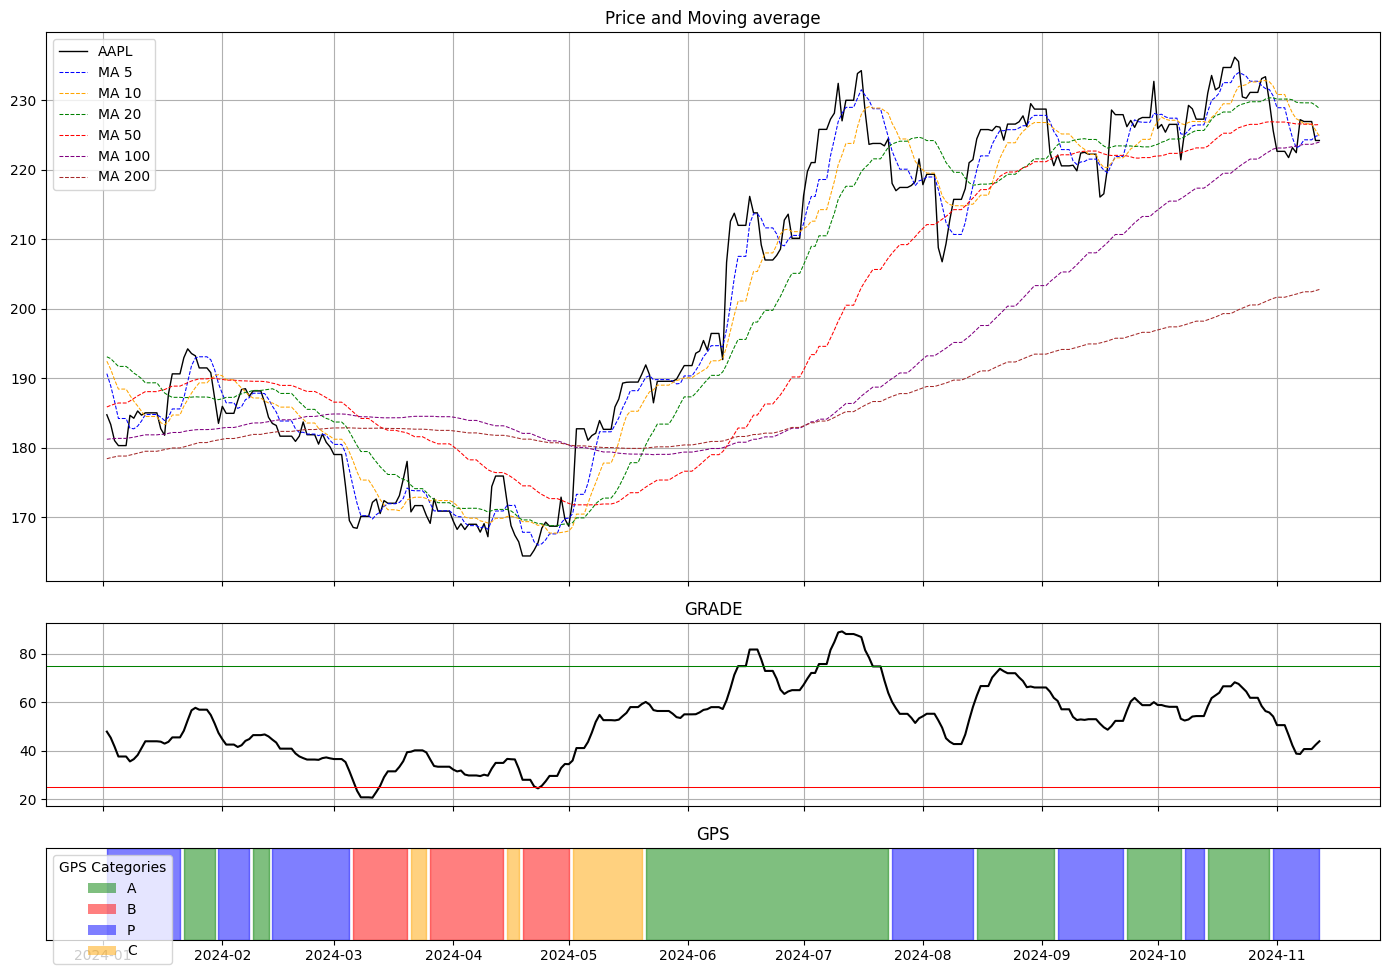

In [15]:
ticker = 'AAPL'
history = yf.Ticker(ticker).history('max')['Close'].tz_localize(None).dropna()
history.name = ticker
df = eclairys_v1(history)
df = df.loc['2024':]
df = df.resample('D').ffill()

# Créer la figure et les sous-graphiques
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 0.5]})

# 1er graphique : Prix TSLA et moyennes mobiles
ax1.plot(df.index, df[ticker], label=ticker, color='black', linewidth=1)
ax1.plot(df.index, df['MA 5'], label='MA 5', linestyle='--', color='blue', linewidth=0.75)
ax1.plot(df.index, df['MA 10'], label='MA 10', linestyle='--', color='orange', linewidth=0.75)
ax1.plot(df.index, df['MA 20'], label='MA 20', linestyle='--', color='green', linewidth=0.75)
ax1.plot(df.index, df['MA 50'], label='MA 50', linestyle='--', color='red', linewidth=0.75)
ax1.plot(df.index, df['MA 100'], label='MA 100', linestyle='--', color='purple', linewidth=0.75)
ax1.plot(df.index, df['MA 200'], label='MA 200', linestyle='--', color='brown', linewidth=0.75)
ax1.legend(loc='upper left')
ax1.set_title('Price and Moving average')
ax1.grid(True)

# 2ème graphique : Note (GRADE)
ax2.plot(df.index, df['GRADE'], color='black')
ax2.axhline(y=75, color='green', linewidth=0.75)
ax2.axhline(y=25, color='red', linewidth=0.75)
ax2.set_title('GRADE')
ax2.grid(True)

# 3ème graphique : GPS avec bande de couleurs
gps_colors = {'A': 'green', 'B': 'red', 'P': 'blue', 'C': 'orange'}
for grade, color in gps_colors.items():
    mask = df['GPS'] == grade
    ax3.fill_between(df.index, 0, 1, where=mask, color=color, alpha=0.5, transform=ax3.get_xaxis_transform())

ax3.set_title('GPS')
ax3.set_yticks([])

# Ajouter la légende pour GPS
legend_elements = [Patch(facecolor='green', label='A', alpha=0.5),
                   Patch(facecolor='red', label='B', alpha=0.5),
                   Patch(facecolor='blue', label='P', alpha=0.5),
                   Patch(facecolor='orange', label='C', alpha=0.5)]
ax3.legend(handles=legend_elements, loc='upper left', title='GPS Categories')

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()